# **Presidential Texts and Declining Reading Levels**
Angela Wilson <br>
University of Colorado Boulder <br>
DTSA 5510: Unsupervised Algorithms in Machine Learning <br>
11/08/2025

<br>

---
---
## **Introduction**

---
#### **Project Topic**

It would be reasonable to expect that texts generated by the government would written at a level understandable by the general public. However, concerns have been raised about declining reading proficiency levels in the United States over the last three decades. Has this decrease in readability levels been reflected in presidential speeches, interviews, and other documents over time?

This project examines a corpus of presidential texts from
[The American Presidency Project](https://www.presidency.ucsb.edu/https://www.presidency.ucsb.edu/)
and uses unsupervised learning models to classify these texts as either public-facing or internal. From here, readability scores (Flesch-Kincaid grade level and Coleman-Liau index) were measured for each text and compared with contemporaneous NAEP reading scores (NAEP Main and NAEP LTT) for 12th graders and 17-year olds as proxies for average reading levels of young adults upon exiting the K-12 education system. Our goal was to determine whether or not the readability levels of these of presidential texts have decreased over time, and whether or not that differs between public-facing and internal texts. And if readability levels have indeed dropped, we wanted to see if this was associated with any particular president, political party, or even time as measured in years.

<br>

---
---
## **Methods**

---
### **Data Scraping**

Initial datasets for this project were scraped online from a variety of sources. Please refer to the accompanying notebook for more details on the data collection pipelines used.

> [Download data](https://github.com/apalomer86/Presidential_Texts_and_Decreasing_Reading_Levels/blob/main/Download%20Data.ipynb)

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
from IPython.display import display, HTML, Markdown

from rapidfuzz import process, fuzz
import textstat
import re
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

<br>

---
### **Import Data**

---
#### **NAEP Data**

[NAEP](https://nces.ed.gov/nationsreportcard/https://nces.ed.gov/nationsreportcard/),
or the National Assessment of Educational Progress, is a national program used to measure student achievement across various core subject areas. Data from these assessments is used to generate
[the Nation's Report Card](https://www.nationsreportcard.gov/https://www.nationsreportcard.gov/),
which can be used to assess how well students are meeting targeted learning goals at national, state, and urban-district levels. For the purposes of this project, we examined results from the NAEP assessments in reading comprehension—NAEP Main and NAEP LTT (Long-Term Trends)—as a proxy for average reading levels of young American adults upon exiting the K-12 education system. Scores for both assessments are given on a
$0-500$
scale.

---
##### **NAEP Main**

Beginning in 1992, NAEP Main has been administered to students at grades 4, 8, and 12. Since our goal was to measure readability levels of texts aimed at the average American adult, we took the reported national average scale score for 12th graders from 1992 up to the most recent assessment in 2024. Original data showed that the year 1998 had values for students who were allowed to take the test with accommodations and those who were not. To clean these duplicate years from the dataset, we took the average score across both groups.

Visit the [Nations's Report Card](https://nces.ed.gov/nationsreportcard/reading/achieve.aspx#2009ald)
website for more detailed explanations on the meanings of the scores. All scores in our dataset are within the cutoff points given below.

| **NAEP Main Average Scale Score** | **Performance Level** |
|:-----------------------------:|---------------------------|
| $265$                         | NAEP Basic                |
| $302$                         | NAEP Proficient           |

In [2]:
# Import NAEP Main data
naep_main = pd.read_csv("data/NAEP-Main, Reading, Grade 12.csv")

# Get all other years except 1998
other_years = naep_main[naep_main["Year"] != 1998][["Year", "Average scale score", "Standard deviation"]]

# Get average scores for 1998
year_1998 = naep_main[naep_main["Year"] == 1998]
year_1998_avg = {
    "Year": 1998,
    "Average scale score": year_1998["Average scale score"].mean(),
    "Standard deviation": year_1998["Standard deviation"].mean()
}
year_1998_df = pd.DataFrame([year_1998_avg])

# Combine into cleaned NAEP Main data
naep_main_clean = (
    pd.concat(
        [other_years, year_1998_df],
        ignore_index=True
    )
    .sort_values("Year")
    .reset_index(drop=True)
)
naep_main_clean = (
    naep_main_clean.rename(
        columns = {"Average scale score": "Average scale score (Main)",
                   "Standard deviation": "Standard deviation (Main)"}
    )
)

display(HTML(f"<b>NAEP Main, Reading, Grade 12</b>"))
naep_main_clean

,Year,Average scale score (Main),Standard deviation (Main)
0,1992,292.149889,32.813342
1,1994,287.346809,36.655904
2,1998,290.475660,37.850842
3,2002,286.864574,37.182550
4,2005,286.027011,38.281354
5,2009,288.272067,38.163986
6,2013,288.431205,37.836875
7,2015,287.030794,40.569975
8,2019,285.481588,42.299205
9,2024,282.648070,42.877234


---
##### **NAEP LTT (Long-Term Trends)**

From 1971 and onwards, NAEP LTT has been administered roughly every four years to students at ages 9, 13, and 17. We took the reported national average scale scores of 17-year-olds from 1971 up to the most recent available data from 2012. The assessments used for NAEP LTT have remained relatively unchanged since the 1990s, so changes in trends seen in this dataset are more stable than those seen in NAEP Main. Data from the year 2004 had values for students who were allowed to take the test with accommodations and those who were not. Like we did with the NAEP Main data, we cleaned these duplicate years by taking the average score across both groups.

Visit the [Nations's Report Card](https://nces.ed.gov/nationsreportcard/reading/achieve.aspx#2009ald)
website for more detailed explanations on the meanings of the scores. All scores in our dataset are within the cutoff points given below.

| **NAEP LTT Average Scale Score**  | **Performance Level**                                    |
|:---------------------------------:|----------------------------------------------------------|
| $300$                             | Understand Complicated Information                       |
| $250$                             | Interrelate Ideas and Make Generalizations               |

In [3]:
# Import NAEP LTT data
naep_ltt = pd.read_csv("data/NAEP-LTT, Reading, Age 17.csv")

# Get all other years except 2004
other_years = naep_ltt[naep_ltt["Year"] != 2004][["Year", "Average scale score", "Standard deviation"]]

# Get average scores for 2004
year_2004 = naep_ltt[naep_ltt["Year"] == 2004]
year_2004_avg = {
    "Year": 2004,
    "Average scale score": year_2004["Average scale score"].mean(),
    "Standard deviation": year_2004["Standard deviation"].mean()
}
year_2004_avg_df = pd.DataFrame([year_2004_avg])

# Combine into cleaned NAEP LTT data
naep_ltt_clean = (
    pd.concat(
        [other_years, year_2004_avg_df],
        ignore_index=True
    )
    .sort_values("Year")
    .reset_index(drop=True)
)
naep_ltt_clean = (
  naep_ltt_clean.rename(
    columns = {"Average scale score": "Average scale score (LTT)",
               "Standard deviation": "Standard deviation (LTT)"}
    )
)

display(HTML(f"<b>NAEP LTT (Long-Term Trends), Reading, Age 17</b>"))
naep_ltt_clean

,Year,Average scale score (LTT),Standard deviation (LTT)
0,1971,285.175219,45.797645
1,1975,285.589857,44.013012
2,1980,285.484572,41.765576
3,1984,288.807578,40.269232
4,1988,290.097685,37.101996
5,1990,290.211751,41.273811
6,1992,289.736427,43.028083
7,1994,288.143732,44.402879
8,1996,287.612871,42.247737
9,1999,287.759440,41.787351


---
We combined both NAEP datasets into a merged table and highlighted non-null values. Then, we plotted these values to show changes in average scale scores over time. Note that while our merged table has `nan` values, we interpolated them before plotting to avoid to breaks in the curves.

In [4]:
# ----------------------------
# Merge NAEP Main and LTT data
# ----------------------------
naep_combined = (
    pd.merge(
        naep_main_clean,
        naep_ltt_clean,
        on="Year",
        how = "outer"
    )
    .sort_values("Year")
    .reset_index(drop=True)
)
naep_combined = naep_combined.loc[:, ~naep_combined.columns.duplicated()]


# Highlight non-null NAEP values
def highlight_naep(s):
    naep_main_color = "#B6D2D3"
    naep_ltt_color = "#FBE9BC"
    col = s.name
    if col in ["Average scale score (Main)", "Standard deviation (Main)"]:
        return [
            f"background-color: {naep_main_color}"
            if pd.notna(v)
            else "" for v in s
        ]
    elif col in ["Average scale score (LTT)", "Standard deviation (LTT)"]:
        return [
            f"background-color: {naep_ltt_color}"
            if pd.notna(v)
            else "" for v in s
        ]
    else:
        return ["" for _ in s]

display(HTML(f"<b>NAEP Main and and NAEP LTT (Long-Term Trends)</b>"))
naep_styled_df = naep_combined.style.apply(highlight_naep, axis=0)
naep_styled_df

,Year,Average scale score (Main),Standard deviation (Main),Average scale score (LTT),Standard deviation (LTT)
0,1971,nan,nan,285.175219,45.797645
1,1975,nan,nan,285.589857,44.013012
2,1980,nan,nan,285.484572,41.765576
3,1984,nan,nan,288.807578,40.269232
4,1988,nan,nan,290.097685,37.101996
5,1990,nan,nan,290.211751,41.273811
6,1992,292.149889,32.813342,289.736427,43.028083
7,1994,287.346809,36.655904,288.143732,44.402879
8,1996,nan,nan,287.612871,42.247737
9,1998,290.475660,37.850842,nan,nan


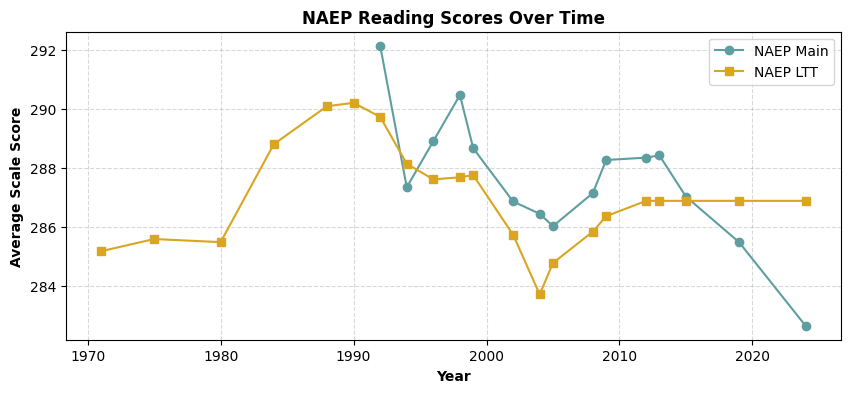

In [5]:
# ----------------------
# Interpolate nan values
# ----------------------
naep_combined["Average scale score (Main)"] = (
    naep_combined["Average scale score (Main)"]
    .interpolate()
)
naep_combined["Average scale score (LTT)"] = (
    naep_combined["Average scale score (LTT)"]
    .interpolate()
)


# -------------------------------------
# Plot NAEP Data w/ interpolated values
# -------------------------------------
plt.figure(figsize = (10, 4))

# NAEP Main
plt.plot(
    naep_combined["Year"],
    naep_combined["Average scale score (Main)"],
    marker = "o",
    color = "CadetBlue",
    label = "NAEP Main"
    )

# NAEP LTT
plt.plot(
    naep_combined["Year"],
    naep_combined["Average scale score (LTT)"],
    marker = "s",
    color = "Goldenrod", label = "NAEP LTT"
    )

plt.xlabel("Year", fontweight = "bold")
plt.ylabel("Average Scale Score", fontweight = "bold")
plt.title("NAEP Reading Scores Over Time", fontweight = "bold")
plt.legend()
plt.grid(True, linestyle = "--", alpha = 0.3, color = "Gray")
plt.show()

<br>

---
#### **Presidential Data**

---
##### **List of US presidents by year and party (Britannica)**

This list of US presidents was scraped from a
[Brittanica](https://www.britannica.com/topic/Presidents-of-the-United-States-1846696https:)
webpage. We cleaned it before importing it into the notebook to create a master list with normalized spellings of president names and filtered our data to contain only presidents who were in office during the years for which NAEP data was available. We also used metadata scraped from that webpage to generate a dataframe called `presidents_df` containing the political party and years in office.

In [6]:
presidents_df = pd.read_csv("data/presidents.csv")

presidents_df["term_start"] = presidents_df["term_start"].astype("Int64")
presidents_df["term_end"] = presidents_df["term_end"].astype("Int64")
presidents_df.rename(columns={"political party": "political_party"}, inplace=True)

# Get minimum year of NAEP data
min_year = naep_combined["Year"].min()

# Filter presidents who were in office at or after min_year
presidents_from_min_year = (
    presidents_df[presidents_df["term_end"] >= min_year]
    .copy()
    .reset_index(drop=True)
)
president_list = presidents_from_min_year["president"].tolist()
display(HTML("<b>President List:</b>"))
display(president_list)

# Presidents in office during NAEP years
president_list = [
    "Richard M. Nixon",
    "Gerald R. Ford",
    "Jimmy Carter",
    "Ronald Reagan",
    "George Bush",
    "Bill Clinton",
    "George W. Bush",
    "Barack Obama",
    "Donald Trump",
    "Joe Biden"
]

# Possible aliases for presidents
aliases = {
    "donald j trump 2nd term": "Donald Trump",
    "donald j trump": "Donald Trump",
    "joseph r biden jr": "Joe Biden",
    "joseph r biden": "Joe Biden",
    "joseph robinette biden": "Joe Biden",
    "richard nixon": "Richard M. Nixon",
    "william j clinton": "Bill Clinton",
    "george bush": "George Bush",
}


# -------------------------
# Normalize president names
# -------------------------
def normalize_text(name):
    if pd.isna(name):
        return ""
    name = name.lower().strip()
    name = re.sub(r"\(.*?\)", "", name)                    # Remove parentheses
    name = re.sub(r"\b(president|pres\.?)\b", "", name)    # Remove titles
    name = re.sub(r"[^\w\s]", "", name)                    # Remove punctuation
    name = re.sub(r"\s+", " ", name).strip()
    return name


# ---------------------------------------
# Map normalized names to president_list
# ---------------------------------------
normalized_president_map = {normalize_text(p): p for p in president_list}
normalized_president_map.update(aliases)


def map_to_president_list(name, normalized_map, threshold=80):
    if not name or pd.isna(name):
        return None

    normalized_name = normalize_text(name)
    match, score, _ = process.extractOne(
        normalized_name,
        normalized_map.keys(),
        scorer = fuzz.token_sort_ratio
    )
    return normalized_map[match] if score >= threshold else None

['Richard M. Nixon',
 'Gerald R. Ford',
 'Jimmy Carter',
 'Ronald Reagan',
 'George Bush',
 'Bill Clinton',
 'George W. Bush',
 'Barack Obama',
 'Donald Trump',
 'Joe Biden']

---
##### **Presidential Text (American Presidency Project)**

To create a corpus of texts to analyze, we scraped a variety of presidential documents from
[The American Presidency Project](https://www.presidency.ucsb.edu/documents).
This allowed us to collect text samples either written or delivered by the US presidents during their term in office. Note that at this time, texts have NOT been labeled as either public-facing or internal. Documents were taken from the following categories:

  * Eulogies
  * Farewell Addresses
  * Fireside Chats
  * Inaugural Addresses
  * Interviews
  * Messages
  * News Conferences
  * Weekly Addresses
  * State of Union Addresses

Once all documents were collected, we had a sample size of
$18,144$
texts to analyze.

We filtered this whole corpus of datasets to include only presidents were in office during the years for which NAEP data was available and combined them all to create a new dataset called `presidential_text_df`. We merged this with our metadata from `presidents_df` to get political party and years in office for each president. We used the `date` each document was published to extract the variable `Year` and used that new variable to merge `naep_combined`. Null NAEP values were interpolated linearly by year.

In [7]:
# -------------------------------------
# Import all presidential text datasets
# -------------------------------------
eulogy_df = pd.read_csv("data/eulogy.csv")
farewell_address_df = pd.read_csv("data/farewell_address.csv")
fireside_chat_df = pd.read_csv("data/fireside_chat.csv")
inaugural_address_df = pd.read_csv("data/inaugural_address.csv")
interview_df = pd.read_csv("data/interview.csv")
message_df = pd.read_csv("data/message.csv")
news_conference_df = pd.read_csv("data/news_conference.csv")
weekly_address_df = pd.read_csv("data/weekly_address.csv")
sotu_address_df = pd.read_csv("data/sotu_address.csv")

all_datasets = [
    "eulogy_df",
    "farewell_address_df",
    "fireside_chat_df",
    "inaugural_address_df",
    "interview_df",
    "message_df",
    "news_conference_df",
    "weekly_address_df",
    "sotu_address_df"
]


# ----------------------------------------------------------
# Filter datasets for presidents in office during NAEP years
# ----------------------------------------------------------
for df_name in all_datasets:
    df = globals().get(df_name)
    if isinstance(df, pd.DataFrame) and "president" in df.columns:
        df_copy = df.copy()
        df_copy["president_mapped"]=df_copy["president"].apply(
              lambda x: map_to_president_list(x, normalized_president_map)
              )
        df_filtered = df_copy[df_copy["president_mapped"].notna()].copy()
        df_filtered["president"] = df_filtered["president_mapped"]
        df_filtered = df_filtered.drop(columns="president_mapped")
        globals()[f"{df_name}_filtered"] = df_filtered
    else:
        break

filtered_datasets = [
    "eulogy_df_filtered",
    "farewell_address_df_filtered",
    "fireside_chat_df_filtered",
    "inaugural_address_df_filtered",
    "interview_df_filtered",
    "message_df_filtered", 
    "news_conference_df_filtered",
    "weekly_address_df_filtered",
    "sotu_address_df_filtered"
    ]


# ---------------------------------------------------
# Combine filtered datasets into presidential_text_df
# ---------------------------------------------------
dfs_to_concat = []
for df_name in filtered_datasets:
    df = globals().get(df_name)
    if isinstance(df, pd.DataFrame) and not df.empty:
        dfs_to_concat.append(df)
presidential_text_df = pd.concat(dfs_to_concat, ignore_index = True)
presidential_text_df = (
    presidential_text_df.drop_duplicates(
        subset = ["full_text"]
    )
    .reset_index(drop=True)
)

In [8]:
# ----------------------------------------
# Merge political_party from presidents_df
# ----------------------------------------
presidents_df_copy = presidents_df.copy()

# Normalize president names for mapping
presidents_df_copy["president_normalized"] = presidents_df_copy["president"].apply(lambda x: x.strip())

# Create mapping from president name to political_party
party_mapping = presidents_df_copy.set_index("president_normalized")["political_party"].to_dict()

# Add political_party column
presidential_text_df["political_party"] = presidential_text_df["president"].map(party_mapping)

In [9]:
# Extract "Year" from "date" in presidential_text
presidential_text_df["Year"] = pd.to_datetime(presidential_text_df["date"]).dt.year
presidential_text_df = presidential_text_df.dropna().reset_index(drop=True)

# -------------------------------------------------------
# Merge presidential_text_df with naep_combined on "Year"
# -------------------------------------------------------
merged_df = pd.merge(
    presidential_text_df,
    naep_combined,
    on="Year",
    how="left"
)

naep_cols = ["Year", "Average scale score (Main)", "Average scale score (LTT)"]
final_columns = naep_cols + [c for c in presidential_text_df.columns if c != "Year"]

presidential_text_naep = merged_df[final_columns]

# Sort by "Year"
presidential_text_naep = presidential_text_naep.sort_values("Year")

# Interpolate missing values linearly by year
presidential_text_naep[naep_cols] = (
    presidential_text_naep[naep_cols]
    .interpolate(method="linear", limit_direction="both")
)

Finally, we called the `textstat` library to compute the Flesch-Kincaid and Coleman-Liau readability scores for each text in our `presidential_text_df` dataset. Both of these readability tests have been used since 1975 to measure text complexity. Unlike the NAEP scores which range on a scale of
$0-500$,
both of these readability scores map to average grade level performance of American students. Generally speaking, texts encountered in daily life typically range from a grade level of
$0-12$,
but can go higher than
$20$
for complicated texts written at a PhD level. Texts with a readability level
$<5$
are indicative of texts that are easy to read, such as children's books. Readability levels of
$8-12$
are the average complexity for most public texts, including news stories and general nonfiction pieces. Readability levels
$\ge 13$
are found in complex texts such as academic journals or legal documents. Both readability tests measure slightly different aspects of text complexity.


  * **Flesch-Kincaid** grade level scores are based on the formula given below and uses total counts for words, sentences, and syllables. While this measure captures general readability well, it does not account for vocabulary difficulty.

    $$
    \textsf{Flesch-Kincaid Grade Level}
        = 0.39 \cdot
            \left(
                \dfrac{\textsf{total words}}
                      {\textsf{total sentences}}
                \right) +
          11.8 \cdot
              \left(
                  \dfrac{\textsf{total syllables}}
                        {\textsf{total words}}
                  \right) -
          15.59
    $$


  * **Coleman-Liau** index scores are based on the formula given below and uses total counts for words, sentences, and letters. Because this measure focuses on text length, it does not necessarily account for complex syntactic structures and tends to yield higher grade level scores than the Flesch-Kincaid readability test.

    $$
    \textsf{Coleman-Liau Index}
        = 0.0588 \cdot
            \left(
                \dfrac{\textsf{total letters}}
                      {\textsf{total words}}
                \right) -
          0.296 \cdot
            \left(
                \dfrac{\textsf{total sentences}}
                      {\textsf{total words}}
                \right) -
          15.8
    $$

In [10]:
tqdm.pandas(desc="Calculating readability metrics")

# Apply Flesch-Kincaid grade to each row
presidential_text_naep["flesch_kincaid"] = (
    presidential_text_naep["full_text"]
    .progress_apply(lambda x: textstat.flesch_kincaid_grade(x))
)

# Apply Coleman-Liau index grade to each row
presidential_text_naep["coleman_liau"] = (
    presidential_text_naep["full_text"]
    .progress_apply(lambda x: textstat.coleman_liau_index(x))
)

Calculating readability metrics: 100%|████████████████████████████████████████████| 8440/8440 [00:11<00:00, 766.96it/s]


<br>

<br>

---
### **Initial EDA (Exploratory Data Analysis): Inspect, Visualize, and Clean the Data**

---
##### **Number of texts per `text_category`**

We begin our EDA (exploratory data analysis) by creating a bar plot showing the number of texts in our dataset by the `text_category` they were assigned when we initially scraped the data from the American Presidency Project. We also added lines to indicate the average Flesch-Kincaid and Coleman-Liau readability scores. The majority of our dataset is is comprised of "message" texts. This category also holds the highest readability scores for both Flesch-Kincaid and Coleman-Liau. The lowest readability scores were found for our "eulogy" texts. "Farewell address" makes up the smallest `text_category` in our dataset.

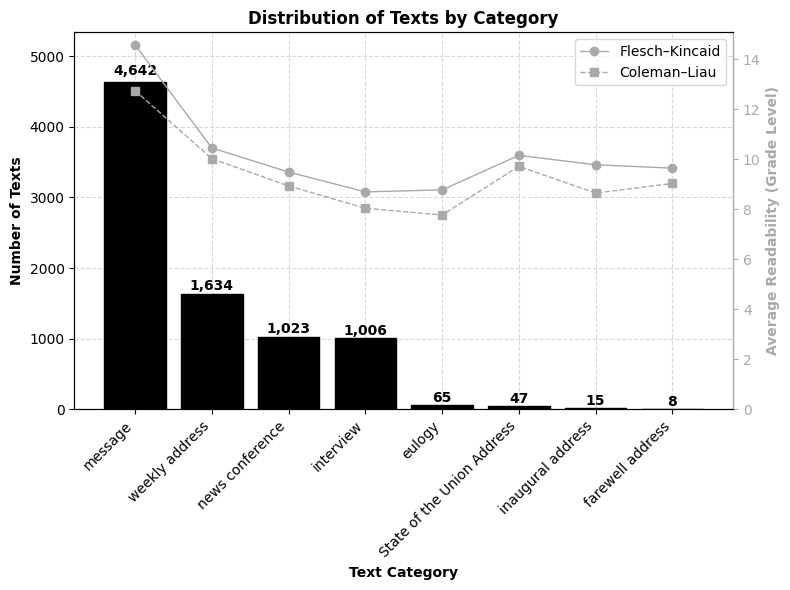

In [36]:
# Number of texts by category
category_counts = presidential_text_naep["text_category"].value_counts()

# Flesch-Kincaid and Coleman-Liau Readability grades by category
readability_means = (
    presidential_text_naep
    .groupby("text_category")[["flesch_kincaid", "coleman_liau"]]
    .mean()
    .reindex(category_counts.index)
)


# -----------------------------------------------
# Plot bars for distribution of texts by category
# -----------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 6))
bars = ax1.bar(
    category_counts.index,
    category_counts.values,
    color="Black",
    edgecolor="Black",
    zorder=3
)
ax1.grid(True, linestyle="--", alpha=0.3, color="Gray", zorder=0)
ax1.set_title("Distribution of Texts by Category", fontweight="bold")
ax1.set_ylabel("Number of Texts", fontweight="bold")
ax1.set_xlabel("Text Category", fontweight="bold")
ax1.set_ylim(0, max(category_counts) * 1.15)
for i, count in enumerate(category_counts):
    ax1.text(
        i, count + (count * 0.01),
        f"{count:,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        zorder=4
       )


# -----------------------------------------------------------------
# Plot lines for Flesch-Kincaid and Coleman-Liau readability grades
# -----------------------------------------------------------------
ax2 = ax1.twinx()
ax2.spines["right"].set_color("DarkGray")
ax2.tick_params(axis="y", colors="DarkGray")
ax2.set_ylabel("Average Readability (Grade Level)", color="DarkGray", fontweight="bold")
x_positions = np.arange(len(readability_means.index))
offset = 0.0
ax2.plot(
    x_positions - offset,
    readability_means["flesch_kincaid"],
    color="DarkGray",
    marker="o",
    linewidth = 1,
    linestyle = "-",
    label="Flesch–Kincaid"
)
ax2.plot(
    x_positions + offset,
    readability_means["coleman_liau"],
    color="DarkGray",
    marker="s",
    linewidth=1,
    linestyle="--",
    label="Coleman–Liau"
)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(readability_means.index, rotation=45, ha="right")
min_score = min(readability_means.min())
max_score = max(readability_means.max())
ax2.set_ylim(0, max_score + 0.5)

ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

---
##### **Number of texts per `president`**

Next, we created a bar plot to show the distribution of texts by president and colored these bars red and blue to represent political party—red for Republican and blue for Deomcrat. Bill Clinton had the highest number of texts in the dataset while Joe Biden had the lowest number. The highest Flesch-Kincaid grade level scores went to Joe Biden, while the lowest scores went to Barrack Obama. The highest Coleman-Liau index scores went to Richard M. Nixon, while the lowest scores went to George W. Bush.

Except for the Trump (2016) - Biden (2020) - Trump (2024) sequence of presidencies at the tail end of this timeline , this plot shows an almost chronological snapshot of the political parties holding the president's office. While the majoriy of the presidents in office have been Republican, highs and lows across readability scores have been found across both parties. Additionally, both readability scores how a general downward trend across all presidents over time, save for a brief spike between Barrack Obama and Joe Biden.

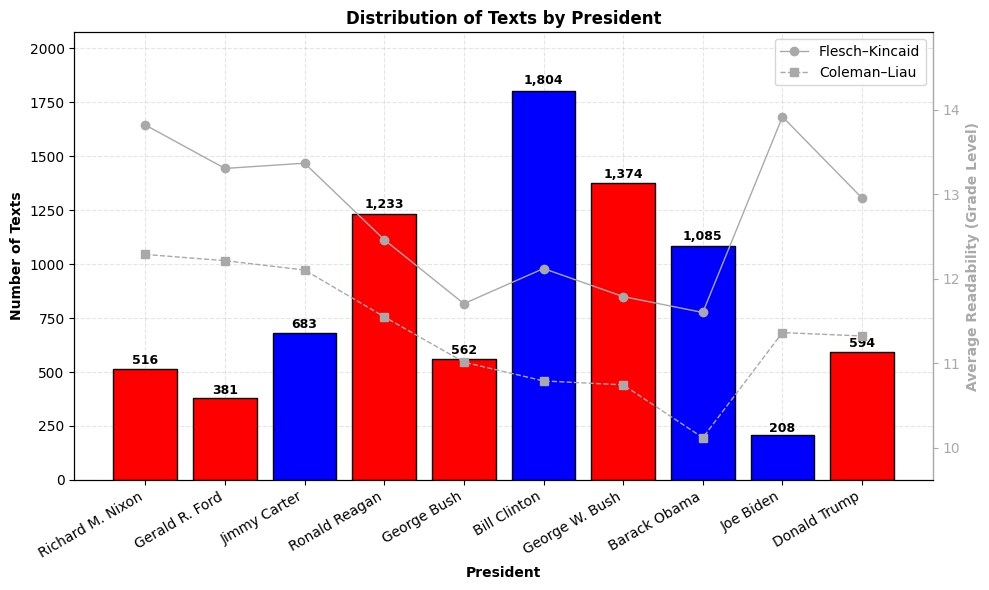

In [12]:
# Number of texts by president
president_counts = presidential_text_naep["president"].value_counts()
president_order = (
    presidential_text_naep.groupby("president")["Year"]
    .min()
    .sort_values()
    .index
)
president_counts = president_counts.reindex(president_order)

# Flesch-Kincaid and Coleman-Liau Readability Grades by President
readability_means_pres = (
    presidential_text_naep.groupby("president")[["flesch_kincaid", "coleman_liau"]]
    .mean()
    .reindex(president_order)
)


fig, ax1 = plt.subplots(figsize=(10, 6))


# -----------------------------
# Map president to party colors
# -----------------------------
president_party_map = (
    presidential_text_naep.drop_duplicates(subset=["president"])
    .set_index("president")["political_party"]
    .to_dict()
)
party_colors = []
for pres in president_counts.index:
    party = president_party_map.get(pres, "")
    if "Republican" in party:
        party_colors.append("Red")
    elif "Democrat" in party:
        party_colors.append("Blue")


# ------------------------------------------------
# Plot bars for distribution of texts by president
# ------------------------------------------------
bars = ax1.bar(
    president_counts.index,
    president_counts.values,
    color=party_colors,
#    edgecolor="Black",
    zorder=3,
)
ax1.grid(True, linestyle="--", alpha=0.3, color="DarkGray", zorder=0)
ax1.set_title("Distribution of Texts by President", fontweight="bold")
ax1.set_ylabel("Number of Texts", fontweight="bold")
ax1.set_xlabel("President", fontweight="bold")
ax1.set_ylim(0, president_counts.max() * 1.15)
for i, count in enumerate(president_counts):
    ax1.text(
        i,
        count + (count * 0.01),
        f"{count:,}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
        zorder=4,
    )


# -----------------------------------------------------------------
# Plot lines for Flesch-Kincaid and Coleman-Liau readability grades
# -----------------------------------------------------------------
ax2 = ax1.twinx()
ax2.spines["right"].set_color("DarkGray")
ax2.tick_params(axis="y", colors="DarkGray")
ax2.set_ylabel("Average Readability (Grade Level)", color="DarkGray", fontweight="bold")
x_positions = np.arange(len(readability_means_pres.index))
offset = 0.0
ax2.plot(
    x_positions - offset,
    readability_means_pres["flesch_kincaid"],
    color="DarkGray",
    marker="o",
    linewidth = 1,
    linestyle="-",
    label="Flesch–Kincaid",
)
ax2.plot(
    x_positions + offset,
    readability_means_pres["coleman_liau"],
    color="Black",
    marker="s",
    linewidth = 1,
    linestyle="--",
    label="Coleman–Liau",
)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(readability_means_pres.index, rotation=30, ha="right")
min_score = min(readability_means_pres.min())
max_score = max(readability_means_pres.max())
ax2.set_ylim(min_score - 0.5, max_score + 1)

ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

<br>

---
---
### **Data Processing**

---
##### **Split dataset into train set and test set**

After conducting our initial EDA, we're ready to apply a train-test split. Our dataset as a whole currently has
$8,440$
text samples. For this notebook, we opted to do a
$90-10$
split between our train set and test set. While this may seem heavily unbalanced towards the train set, our test size post-split comes out to
$844$,
which is still large enough for out results to be generalizable.

We also noticed during our EDA that our raw data was heavily skewed towards the `text_category`: "message" and the `political_party`: "Republican". Because of this, we stratified our split across `text_category`, `political_party`, and `president` to avoid having any of those groups over-or-under-represented in either our train or test sets.

In [13]:
presidential_text_naep["stratify_key"] = (
    presidential_text_naep["text_category"].astype(str) + "_" +
    presidential_text_naep["political_party"].astype(str) + "_" +
    presidential_text_naep["president"].astype(str)
)

strat_counts = presidential_text_naep["stratify_key"].value_counts()
min_samples = 5
rare_classes = strat_counts[strat_counts < min_samples].index
presidential_text_naep.loc[
    presidential_text_naep["stratify_key"].isin(rare_classes), "stratify_key"
] = "OTHER"

train_data, test_data = train_test_split(
    presidential_text_naep,
    test_size=0.1,
    random_state=42,
    stratify=presidential_text_naep["stratify_key"]
)

train_data = train_data.reset_index(drop=True).drop(columns=["stratify_key"])
test_data = test_data.reset_index(drop=True).drop(columns=["stratify_key"])

display(HTML(f"<b>Train Set Shape: </b> &emsp; {train_data.shape}"))
display(HTML(f"<b>Test Set Shape: </b> &emsp;  {test_data.shape}"))

---
##### **Basic text cleaning with regex**

Once our data was properly split, we called on the `re` library to apply regex to to our `full_text` column. We removed HTML tags, digits, punctuation, multiple spaces, and set all characters to lowercase for consistency. This creates a new column in our dataset called `clean_text`.

In [14]:
tqdm.pandas(desc="Cleaning text with regex")


def clean_text_regex(text):
    text = re.sub(r"<[^>]+>", " ", text)      # Remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Remove digits and punctuation
    text = re.sub(r"\s+", " ", text)          # Remove multiple spaces
    return text.lower()

train_data["clean_text"] = train_data["full_text"].progress_apply(clean_text_regex)
test_data["clean_text"] = test_data["full_text"].progress_apply(clean_text_regex)

Cleaning text with regex: 100%|████████████████████████████████████████████████████| 844/844 [00:00<00:00, 1967.48it/s]


---
##### **Get number of total raw and unique tokens**

After we generate our `clean_text`, we load the English small language model from the library `spaCy` and run our `clean_text` throuh our NLP pipeline. To speed things up, we set `disable=["tok2vec"]` because we will be vectorizing the tokens later on our own using TF-IDF. For now, we just want the total number of raw tokens and unique tokens for both our train and test sets.

In [15]:
nlp = spacy.load("en_core_web_sm")


# ---------------------------------------------------
# Get number of total raw and unique train set tokens
# ---------------------------------------------------
docs_train = (
    list(
        nlp.pipe(
            tqdm(train_data["clean_text"], desc="Processing train texts"),
            disable=["tok2vec"])
    )
)
total_tokens_train = sum(len(doc) for doc in docs_train)
unique_tokens_train = set(token.text.lower() for doc in docs_train for token in doc
)
display(HTML(f"<b>Total Tokens in Train Data: &nbsp;</b> {total_tokens_train}"))
display(HTML(f"<b>Unique Tokens in Train Data: &nbsp;</b> {len(unique_tokens_train)}"))


# ---------------------------------------------------
# Get number of total raw and unique test set tokens
# ---------------------------------------------------
docs_test = (
    list(
        nlp.pipe(
            tqdm(test_data["clean_text"], desc="Processing test texts"),
            disable=["tok2vec"])
    )
)
total_tokens_test = sum(len(doc) for doc in docs_test)
unique_tokens_test = set(token.text.lower() for doc in docs_test for token in doc)
display(HTML(f"<b>Total Tokens in Test Data: &nbsp;</b> {total_tokens_test}"))
display(HTML(f"<b>Unique Tokens in Test Data: &nbsp;</b> {len(unique_tokens_test)}"))

Processing train texts: 100%|██████████████████████████████████████████████████████| 7596/7596 [15:34<00:00,  8.13it/s]


Processing test texts: 100%|█████████████████████████████████████████████████████████| 844/844 [01:40<00:00,  8.36it/s]


---
##### **Lemmatization**

Now that we have our total and unique token counts, we can apply lemmatization to clean this further. This reduces words to their base dictionary form to preserve meaning for clustering while keeping features interpretable. (For example, "running" becomes "run.")  We also remove stop words that add little to no semantic meaning to our text (ex. "is", "a", "the", etc.). Then, we remove any spaces and punctuation that might have gotten missed when we ran our text through regex, along with words that are like numbers. We also make sure the tokens left after this cleanup process are either nouns, verbs, adjectives, or proper nouns. Finally, we can get a number of lemmatized tokens for both out train and test sets.

In [16]:
def clean_text_lemma(doc):
    return " ".join(
        token.lemma_.lower()
        for token in doc
        if not token.is_stop
        and not token.is_punct
        and not token.is_space
        and not token.like_num
        and token.pos_ in {"NOUN", "VERB", "ADJ", "PROPN"}
    )


# ---------------------------------------
# Get number of lemma tokens in train set
# ---------------------------------------
train_data["clean_text_lemma"] = (
    [clean_text_lemma(doc) for doc in tqdm(docs_train, desc="Lemmatizing train texts")]
)
train_data.loc[0, "clean_text_lemma"]
lemma_tokens_train = set(word for text in train_data["clean_text_lemma"] for word in text.split())
display(HTML(f"<b>Lemma Tokens in Train Data: &emsp;</b> {len(lemma_tokens_train)}"))
tqdm.pandas(desc="Lemmatizing test texts")


# --------------------------------------
# Get number of lemma tokens in test set
# --------------------------------------
test_data["clean_text_lemma"] = (
    [clean_text_lemma(doc) for doc in tqdm(docs_test, desc="Lemmatizing train texts")]
)
test_data.loc[0, "clean_text_lemma"]
lemma_tokens_test = set(word for text in test_data["clean_text_lemma"] for word in text.split())
display(HTML(f"<b>Lemma Tokens in Test Data: &emsp;</b> {len(lemma_tokens_test)}"))

Lemmatizing train texts: 100%|███████████████████████████████████████████████████| 7596/7596 [00:04<00:00, 1579.54it/s]


Lemmatizing train texts: 100%|█████████████████████████████████████████████████████| 844/844 [00:00<00:00, 1467.10it/s]


---
##### **Vectorization and TF-DIF**

Next, we apply the `sklearn` implementation of `TfidfVectorizer()` to our cleaned and lemmatized texts to create matrices we can use for analysis. TF-IDF (Term Frequency-Inverse Document Frequency) gives a weight to every word in each document based on that word's relative frequency within a larger collection of documents. That weight serves as a proxy measure for the importance of that word within the dataset as a whole.

In [17]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(train_data["clean_text_lemma"])

Next, we feed the resulting TF-IDF matrix into our model. From here, we can get the number of tokens for both our train and test sets after we apply TF-IDF on our lemmatized tokens.

In [18]:
# ----------------------------------------------
# Get number of TF-IDF lemma tokens in train set
# ----------------------------------------------
train_lemma_texts = [
    text for text in tqdm(train_data["clean_text_lemma"], desc="Loading train lemma texts")
]
vectorizer = TfidfVectorizer(max_features=6000)
lemma_tfidf_train = vectorizer.fit_transform(train_lemma_texts)
display(HTML(f"<b>Train Data Shape after TF-IDF Processing: &nbsp;</b> {lemma_tfidf_train.shape}"))
features_train = np.array(vectorizer.get_feature_names_out())
tfidf_train = pd.DataFrame(lemma_tfidf_train.toarray(), columns=features_train)


# ---------------------------------------------
# Get number of TF-IDF lemma tokens in test set
# ---------------------------------------------
test_lemma_texts = [
    text for text in tqdm(test_data["clean_text_lemma"], desc="Loading test lemma texts")
]
vectorizer = TfidfVectorizer(max_features=6000)
lemma_tfidf_test = vectorizer.fit_transform(test_lemma_texts)
display(HTML(f"<b>Test Data Shape after TF-IDF Processing: &nbsp;</b> {lemma_tfidf_test.shape}"))
features_test = np.array(vectorizer.get_feature_names_out())
tfidf_test = pd.DataFrame(lemma_tfidf_test.toarray(), columns=features_test)

Loading train lemma texts: 100%|██████████████████████████████████████████████| 7596/7596 [00:00<00:00, 1685978.37it/s]


Loading test lemma texts: 100%|██████████████████████████████████████████████████████████████| 844/844 [00:00<?, ?it/s]


<br>

---
---
## **Models and Results**

---
### **Assign Text into Clusters**

---
#### **K-means Clustering**

To classify our texts into either public-facing or internal categories, we apply k-means clustering by setting
$k = 2$
to get two clusters for each of our desired categories.

After we apply k-means clustering, we plot out the top
$20$
words per cluster. Our clusters are still unlabled, but we can start to see which one has a higher reading level likely aimed towards internal texts and which one has a lower reading level aimed at public-facing texts. Based on this, we assign "Cluster 0" to "internal" texts and "Cluster 1" to "public" texts.

In [19]:
# Apply k-means clustering to TF-IDF train set
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_train = kmeans.fit_predict(lemma_tfidf_train)
tfidf_train["Cluster"] = clusters_train

# Apply k-means clustering to TF-IDF test set
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_test = kmeans.fit_predict(lemma_tfidf_test)
tfidf_test["Cluster"] = clusters_test

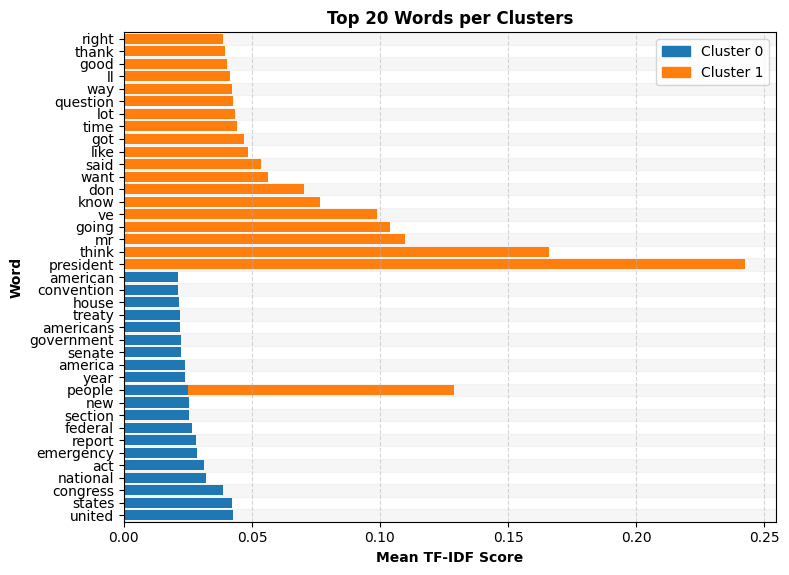

In [20]:
# ----------------------------------
# Plot Top 20 words in each cluster
# ----------------------------------
top_n = 20
counts = tfidf_train["Cluster"].value_counts()
clusters = counts.index
palette = sns.color_palette(n_colors = len(clusters))
counts

plot_data = []

for cluster in clusters:
    subset_train = tfidf_train[
        tfidf_train["Cluster"] == cluster].drop(columns = ["Cluster"])
    mean_tfidf_train = subset_train.mean(axis=0)
    top_words_train = mean_tfidf_train.sort_values(ascending=False).head(top_n)
    for word, score in top_words_train.items():
        plot_data.append(
            {"Cluster": cluster,
             "Word": word,
             "Mean_TFIDF": score}
        )
df_plot = pd.DataFrame(plot_data)
df_plot["Word"] = df_plot["Word"].astype(str)
df_wide = df_plot.pivot_table(
    index="Word",
    columns="Cluster",
    values="Mean_TFIDF",
    fill_value=0
)
df_wide = df_wide.loc[df_plot["Word"].unique()]

fig, ax = plt.subplots(figsize=(8, len(df_wide) * 0.15))
color_dict = {cluster: palette[i] for i, cluster in enumerate(clusters)}
for i, word in enumerate(df_wide.index):
    if i % 2 == 0:
        ax.axhspan(i - 0.5, i + 0.5, color="Gainsboro", alpha=0.25)
bottoms = np.zeros(len(df_wide))
for cluster in clusters:
    ax.barh(
        df_wide.index,
        df_wide[cluster],
        left=bottoms,
        color=color_dict[cluster],
        label=cluster
    )
    bottoms += df_wide[cluster].values

ax.set_title(f"Top {top_n} Words per Clusters", fontweight = "bold")
ax.set_xlabel("Mean TF-IDF Score", fontweight = "bold")
ax.set_ylabel("Word", fontweight = "bold")
ax.set_ylim(-0.5, len(df_wide) - 0.5)
ax.grid(axis="x", linestyle="--", alpha=0.5)
handles = [
    mpatches.Patch(color=color_dict[cluster], label=f"Cluster {cluster}") for cluster in clusters
]
ax.legend(handles=handles)

plt.tight_layout()
plt.show()

In [21]:
# ------------------------------
# Train Set TF-IDF with clusters
# ------------------------------
features_train = [c for c in tfidf_train.columns if c != "Cluster"]
centroids_train = tfidf_train.groupby("Cluster")[features_train].mean()
lemma_tfidf_train = vectorizer.fit_transform(train_lemma_texts)
tfidf_cluster_train_df = pd.DataFrame(lemma_tfidf_train.toarray(), columns=features_train)
similarities_train = cosine_similarity(tfidf_cluster_train_df, centroids_train)
train_data["Predicted_Cluster"] = np.argmax(similarities_train, axis=1)

train_data["Predicted_Cluster_label"] = (
    train_data["Predicted_Cluster"].map({0: "internal", 1: "public"})
)


# -----------------------------
# Test Set TF-IDF with clusters
# -----------------------------
features_test = [c for c in tfidf_test.columns if c != "Cluster"]
centroids_test = tfidf_test.groupby("Cluster")[features_test].mean()
lemma_tfidf_test = vectorizer.fit_transform(test_lemma_texts)
tfidf_cluster_test_df = pd.DataFrame(lemma_tfidf_test.toarray(), columns=features_test)
similarities_test = cosine_similarity(tfidf_cluster_test_df, centroids_test)
test_data["Predicted_Cluster"] = np.argmax(similarities_test, axis=1)
test_data["Predicted_Cluster_label"] = test_data["Predicted_Cluster"].map({0: "internal", 1: "public"})

---
#### **NMF**

Next, we use the `sklearn` implementation of `NMF()` to apply factorization to the clustered data from our previous k-means model. For tuning purposes, we ran the model across different values for `n_topic` to see which iteration would give us the best crosstab and metric values.

The crosstabs show the number of articles in a given NMF topic that were mapped to a particular k-means cluster. Adjusted Rand Score measures the similarity between the topic and the cluster it was mapped to. A score of
$0$
tells us that there is no similarity and this mapping is what we would expect from random assignment. Negative values are are worse than random. A score of
$1$
tells us we have perfect similarity between the cluster and topic. RMSE or root mean squared error evaluates the factorization quality of our NMF model by telling us how well the NMF reconstructs our starting TF-IDF matrix. We want a minimum value to reflect minimal error in the factorization.

In [22]:
def nmf_model_topics(train_data, test_data, n_topics):

    display(Markdown(f"<b>`n_topics = {n_topics}`</b>"))

    vectorizer = TfidfVectorizer(
        max_features = 10000,
        max_df = 0.8,             # Ignore words appearing in 80% of docs
        ngram_range = (1, 2),     # Capture one-word and two-word phrases
        sublinear_tf = True       # Apply log scaling
        )
    X_train = vectorizer.fit_transform(train_data["clean_text_lemma"])
    X_test = vectorizer.transform(test_data["clean_text_lemma"])

    nmf_model = NMF(
        n_components = n_topics,
        init = "nndsvda",
        random_state = 42,
        max_iter = 500
    )

    W_train = nmf_model.fit_transform(X_train)
    H_train = nmf_model.components_
    rmse_train = np.sqrt(np.mean((X_train.toarray() - W_train @ H_train) ** 2))

    # Assign topic IDs
    train_data = train_data.copy()
    train_data["NMF_topic"] = W_train.argmax(axis=1)

    # Map first two topics to public/internal, rest to generic Topic i
    topic_label_map = {0: "public", 1: "internal"}
    topic_label_map.update({i: f"Topic {i}" for i in range(2, n_topics)})
    train_data["NMF_topic"] = W_train.argmax(axis=1)
    train_data["NMF_topic_label"] = train_data["NMF_topic"].map(topic_label_map)

    # Compute cluster to category mapping for test set
    df_train = pd.DataFrame({
        "Predicted_Cluster": train_data["Predicted_Cluster"].values,
        "NMF_topic": train_data["NMF_topic"].values
    })
    pred_cluster_train = (
        df_train.groupby("NMF_topic")["Predicted_Cluster"]
        .agg(lambda x: x.value_counts().idxmax())
        .to_dict()
    )

    # Transform test set
    W_test = nmf_model.transform(X_test)
    test_data = test_data.copy()
    test_data["NMF_topic"] = W_test.argmax(axis=1)  # all rows get values
    test_data["NMF_topic_label"] = test_data["NMF_topic"].map(topic_label_map)
    rmse_test = np.sqrt(np.mean((X_test.toarray() - W_test @ H_train) ** 2))


    # ------------------
    # Train Set Crosstab
    # ------------------
    train_data["NMF_topic"] = W_train.argmax(axis=1)
    display(HTML(f"<b>Train Data Crosstab:</b>"))
    print(pd.crosstab(train_data["Predicted_Cluster"], train_data["NMF_topic"]))


    # -----------------------------------
    # Train Set Metrics
    # -----------------------------------
    from sklearn.metrics import adjusted_rand_score
    train_ari = adjusted_rand_score(train_data["Predicted_Cluster"], train_data["NMF_topic"])
    display(HTML(f"<b>    Train Data Metrics:</b>"))
    print(f"    Adjusted Rand Score:        {train_ari:.4f}")
    print(f"    RMSE:                       {rmse_train:.4f}")
    print("")


    # -----------------
    # Test Set Crosstab
    # -----------------
    test_data["NMF_topic"] = W_test.argmax(axis=1)
    display(HTML(f"<b>Test Data Crosstab:</b>"))
    print(pd.crosstab(test_data["Predicted_Cluster"], test_data["NMF_topic"]))


    # -----------------------------------
    # Test Set Metrics
    # -----------------------------------
    from sklearn.metrics import adjusted_rand_score
    test_ari = adjusted_rand_score(test_data["Predicted_Cluster"], test_data["NMF_topic"])
    display(HTML(f"    <b>Train Data Metrics:</b>"))
    print(f"    Adjusted Rand Score:        {test_ari:.4f}")
    print(f"    RMSE:                       {rmse_test:.4f}")
    print("")

> ---

* **`n_topics = 2`** <br>
    For both the train and test sets, no elements from topic 1 mapped onto cluster 1. While RMSE was low for both the train and test set, both sets achieved a negative value for the adjusted Rand score. This low number of `n_topics` shows poor performance for categorizing texts.

In [23]:
# n_topics = 2
nmf_model_topics_2 = nmf_model_topics(train_data, test_data, n_topics = 2)
nmf_model_topics_2

<b>`n_topics = 2`</b>

NMF_topic             0     1
Predicted_Cluster            
0                  3213  2292
1                  2091     0


    Adjusted Rand Score:        -0.0084
    RMSE:                       0.0095



NMF_topic            0    1
Predicted_Cluster          
0                  362  255
1                  227    0


    Adjusted Rand Score:        -0.0145
    RMSE:                       0.0094



> ---

  * **`n_topics = 5`** <br>
    This parameter gives us the highest adjusted Rand scores so far,
    $0.2908$
    for our train set and
    $0.3030$
    for our test set, suggesting weak to moderate similarity between the topics and clusters. Our low RMSE of
    $0.0092$
    for both the train and set suggests strong performance of the factorization model.

In [24]:
# n_topics = 5
nmf_model_topics_5 = nmf_model_topics(train_data, test_data, n_topics = 5)
nmf_model_topics_5

<b>`n_topics = 5`</b>

NMF_topic             0    1    2     3     4
Predicted_Cluster                            
0                    87  388  623  1676  2731
1                  1817    0    0     1   273


    Adjusted Rand Score:        0.2908
    RMSE:                       0.0092



NMF_topic            0   1   2    3    4
Predicted_Cluster                       
0                    8  44  73  180  312
1                  203   0   0    0   24


    Adjusted Rand Score:        0.3030
    RMSE:                       0.0092



> ---

  * **`n_topics = 10`** <br>
    Increasing the number of topics actually reduced the adjusted Rand scores for both our train and test sets. While both values are still positive, they're still significantly lower the values we reached at `n_topics = 5`, suggesting poorer similarity measures for this iteration of topic-to-cluster mappping. That weaker adjusted Rand score means our previous model is still preferable for categorization purposes despite the lower RMSE score from this iteration.

In [25]:
# n_topics = 10
nmf_model_topics_10 = nmf_model_topics(train_data, test_data, n_topics = 10)
nmf_model_topics_10

<b>`n_topics = 10`</b>

NMF_topic             0    1    2    3     4    5     6    7    8    9
Predicted_Cluster                                                     
0                    15  364  606  930  1007  202  1103  700  301  277
1                  1568    0    0   67   315    0   141    0    0    0


    Adjusted Rand Score:        0.1252
    RMSE:                       0.0090



NMF_topic            0   1   2    3    4   5    6   7   8   9
Predicted_Cluster                                            
0                    1  43  71  106  121  16  121  74  28  36
1                  179   0   0    6   27   0   15   0   0   0


    Adjusted Rand Score:        0.1329
    RMSE:                       0.0090



> ---

Since we achieved the best similarity measures at `n_topics = 5`, we chose this as the final model for our readability analysis.

---
##### **Top Features in Each Cluster**

Based on our best performing model, we printed out the top features (words) in each cluster.

In [26]:
def nmf_model_topics_final(train_data, test_data, n_topics):

    display(Markdown(f"<b>`n_topics = {n_topics}`</b>"))

    vectorizer = TfidfVectorizer(
        max_features = 10000,
        max_df = 0.8,             # Ignore words appearing in 80% of docs
        ngram_range = (1, 2),     # Capture one-word and two-word phrases
        sublinear_tf = True       # Apply log scaling
        )
    X_train = vectorizer.fit_transform(train_data["clean_text_lemma"])
    X_test = vectorizer.transform(test_data["clean_text_lemma"])

    nmf_model = NMF(
        n_components = n_topics,
        init = "nndsvda",
        random_state = 42,
        max_iter = 500
    )

    W_train = nmf_model.fit_transform(X_train)
    H_train = nmf_model.components_
    recon_train = np.linalg.norm(X_train - W_train @ H_train, "fro")
    rmse_train = np.sqrt(np.mean((X_train.toarray() - W_train @ H_train) ** 2))
    cluster_idx_train = W_train.argmax(axis = 1)
    df_train = pd.DataFrame(
        {"Predicted_Cluster": train_data["Predicted_Cluster"].values,
         "Cluster": cluster_idx_train}
    )

    cluster_to_category = (
        df_train.groupby("Cluster")["Predicted_Cluster"]
        .agg(lambda x: x.value_counts().idxmax())
        .to_dict()
    )

    W_test = nmf_model.transform(X_test)
    cluster_idx_test = W_test.argmax(axis = 1)
    pred_cluster_test = [cluster_to_category.get(t, "Unknown") for t in cluster_idx_test]
    recon_test = np.linalg.norm(X_test - W_test @ H_train, "fro")
    rmse_test = np.sqrt(np.mean((X_test.toarray() - W_test @ H_train) ** 2))

    # Assign to notebook global scope
    globals()["W_train"] = W_train
    globals()["H_train"] = H_train
    globals()["W_test"] = W_test
    globals()["vectorizer"] = vectorizer
    globals()["label_map"] = {i: f"Topic {i}" for i in range(H_train.shape[0])}
    globals()["cluster_idx_train"] = cluster_idx_train
    globals()["cluster_idx_test"] = cluster_idx_test

In [27]:
nmf_model_5_final = nmf_model_topics_final(train_data, test_data, n_topics = 5)
top_n = 20
feature_names = vectorizer.get_feature_names_out()

for i, topic_weights in enumerate(H_train):
    top_indices = topic_weights.argsort()[:-top_n-1:-1]
    top_words = [feature_names[idx] for idx in top_indices]
    print(f"Topic {i}: {top_words}\n")

<b>`n_topics = 5`</b>

Topic 0: ['think', 'president', 'mr', 'going', 'mr president', 'don', 've', 'know', 'said', 'question', 'want', 'got', 'lot', 'like', 'people', 'thank', 'things', 'll', 'way', 'yes']

Topic 1: ['emergency', 'national emergency', 'federal register', 'anniversary date', 'continue effect', 'register', 'stating', 'notice stating', 'notice', 'anniversary', 'national', 'date', 'declared', 'stating emergency', 'effect', 'emergency continue', 'executive order', 'declaration', 'emergencies act', 'national emergencies']

Topic 2: ['ratification', 'advice consent', 'senate', 'consent', 'advice', 'convention', 'treaty', 'transmit', 'consent ratification', 'senate united', 'protocol', 'report department', 'department state', 'recommend senate', 'information senate', 'transmit herewith', 'united', 'united states', 'recommend', 'consent senate']

Topic 3: ['report', 'congress united', 'act', 'section', 'congress', 'states accordance', 'deferrals', 'herewith', 'united states', 'united', 'white house',

From here, we mapped each of the topics from our NMF model to a cluster from our k-means model and added these assignments to our train and test sets. Then, we created a plot to show the top
$20$
features (words) within each cluster.

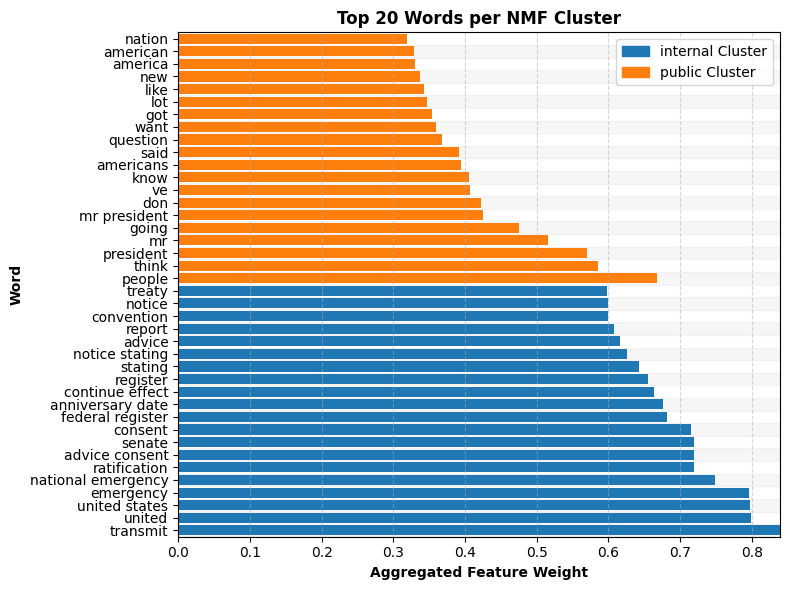

In [28]:
# --------------------------------------------
# Map NMF_topics to k-means Predicted_Clusters
# --------------------------------------------
topic_to_cluster = {
    0: "public", 1: "internal", 2: "internal", 3: "internal", 4: "public"
}
train_data["NMF_topic"] = cluster_idx_train
train_data["NMF_topic_label"] = train_data["NMF_topic"].map(topic_to_cluster)
test_data["NMF_topic"] = cluster_idx_test
test_data["NMF_topic_label"] = test_data["NMF_topic"].map(topic_to_cluster)


plot_data = []
for i, topic_weights in enumerate(H_train):
    if i not in topic_to_cluster:
        continue
    cluster_label = topic_to_cluster[i]
    top_indices = topic_weights.argsort()[:-top_n-1:-1]
    for idx in top_indices:
        plot_data.append({
            "Cluster": cluster_label,
            "Topic": i,
            "Word": feature_names[idx],
            "Weight": topic_weights[idx]
        })

df_plot = pd.DataFrame(plot_data)
df_plot["Word"] = df_plot["Word"].astype(str)

df_cluster = (
    df_plot.groupby(["Cluster", "Word"])["Weight"]
    .sum()
    .reset_index()
)

df_top = df_cluster.groupby("Cluster").apply(lambda x: x.nlargest(top_n, "Weight")).reset_index(drop=True)


# ----------------------------------
# Plot Top 20 words in each NMF cluster
# ----------------------------------
top_n = 20
clusters = df_top["Cluster"].unique()
palette = sns.color_palette(n_colors=len(clusters))

df_wide = df_top.pivot_table(
    index="Word",
    columns="Cluster",
    values="Weight",
    fill_value=0
)
df_wide = df_wide.loc[df_top["Word"].unique()]

fig, ax = plt.subplots(figsize=(8, len(df_wide) * 0.15))
color_dict = {cluster: palette[i] for i, cluster in enumerate(clusters)}

for i, word in enumerate(df_wide.index):
    if i % 2 == 0:
        ax.axhspan(i - 0.5, i + 0.5, color="Gainsboro", alpha=0.25)

bottoms = np.zeros(len(df_wide))
for cluster in clusters:
    ax.barh(
        df_wide.index,
        df_wide[cluster],
        left=bottoms,
        color=color_dict[cluster],
        label=cluster
    )
    bottoms += df_wide[cluster].values

ax.set_title(f"Top {top_n} Words per NMF Cluster", fontweight="bold")
ax.set_xlabel("Aggregated Feature Weight", fontweight="bold")
ax.set_ylabel("Word", fontweight="bold")
ax.set_ylim(-0.5, len(df_wide) - 0.5)
ax.grid(axis="x", linestyle="--", alpha=0.5)
handles = [mpatches.Patch(color=color_dict[cluster], label=f"{cluster} Cluster") for cluster in clusters]
ax.legend(handles=handles)

plt.tight_layout()
plt.show()

<br>

---
### **Readability Analysis with NAEP**

Now that our texts are categorized as either public-facing or internal, we can finally run our analysis of readability levels. Note that all further analyses were conducted using OLS (ordinary least squares regression), but were based on the output obtained from our previous unsupervised learning models (K-means clustering and NMF).

After renaming columns to prepare both our train and test sets for OLS analysis, we defined the OLS function. Our goal was to measure the impact of the variables `year`, `text_category`, `political_party`, `president`, `NAEP_Main` and `NAEP_LTT` on the `Flesch_kincaid` and `Coleman-Liau` readability level scores for each text, and see if this differed across public and internal texts.

  | **Independent Variable**    | **Meaning**                                               |
  |:----------------------------|:----------------------------------------------------------|
  | `Flesch_Kincaid`            | Flesch-Kincaid readability score                          |
  | `Coleman_Liau`              | Coleman-Liau readability score                            |
  |                             |                                                           |
  | **Dependent Variable**      | **Meaning**                                               |
  | `year`                      | year text was published or presented                      |
  | `text_category`             | category of text from the American Presidency Project     |
  | `political_party`           | president's political party                               |
  | `president`                 | name of president                                         |
  | `NAEP_Main`                 | NAEP Main average scale score                             |
  | `NAEP_LTT`                  | NAEP LTT (Long-Term Trends) average scale score           |
  | `NMF_topic_label`           | categorizes text as either *public* or *internal*         |

To measure the strength of our model, we used the adjusted R-squared score to measure goodness of fit between our dependent variables and independent variables. Since our model has multiple variables contributing to the readability score output, we calculated the relative importance of the top feature groups to measure the percentage each dependent variable contributes to the adjusted R-squared score.

In [29]:
# ------------------------------------------------
# Prepare train set for readability level analysis
# ------------------------------------------------
train_data = (
    train_data.rename(
        columns={
            "Year": "year",
            "Average scale score (Main)": "NAEP_Main",
            "Average scale score (LTT)": "NAEP_LTT",
            "coleman_liau": "Coleman_Liau",
            "flesch_kincaid": "Flesch_Kincaid",
            "political party": "political_party"
        }
    )
    .reset_index(drop=True)
)


# -----------------------------------------------
# Prepare test set for readability level analysis
# -----------------------------------------------
test_data = (
    test_data.rename(
        columns={
            "Year": "year",
            "Average scale score (Main)": "NAEP_Main",
            "Average scale score (LTT)": "NAEP_LTT",
            "coleman_liau": "Coleman_Liau",
            "flesch_kincaid": "Flesch_Kincaid",
            "political party": "political_party"
        }
    )
    .reset_index(drop=True)
)

In [30]:
def ols_model_readability(formula, y_label, train_data, test_data):

    display(Markdown(
        f"<b>`{y_label}` $\sim$ "
        f"$($ <b>`year` $+$ `text_category` $+$ `political_party` $+$ `president` $+$ </b>"
        f"<b>`NAEP_Main` + `NAEP_LTT` $) $ $* $ `NMF_topic_label`</b>"
    ))

    # -----------------------------
    # Train Set
    # -----------------------------
    model_train = smf.ols(formula=formula, data=train_data).fit()
    r2_train = model_train.rsquared
    adj_r2_train = model_train.rsquared_adj

    display(HTML(f"<b>Train Adjusted R-squared:</b> &emsp; {adj_r2_train:.4f}"))

    # -----------------------------
    # Test Set
    # -----------------------------
    model_test = smf.ols(formula=formula, data=test_data).fit()
    r2_test = model_test.rsquared
    adj_r2_test = model_test.rsquared_adj

    display(HTML(f"<b>Test Adjusted R-squared:</b> &emsp; {adj_r2_test:.4f}"))
    print("")

    # -----------------------------
    # Feature Importance
    # -----------------------------
    coefs = model_train.params.reset_index()
    coefs.columns = ["feature", "coef"]

    def group_feature(name):
        if ":" in name:
            base = name.split(":")[0]
            return base.split("[")[0].split("T.")[0]
        else:
            return name.split("[")[0].split("T.")[0]

    coefs["group"] = coefs["feature"].apply(group_feature)

    agg_importance = coefs.groupby("group")["coef"].apply(lambda x: np.sum(np.abs(x)))
    rel_importance = 100 * agg_importance / agg_importance.sum()
    rel_importance = rel_importance.sort_values(ascending=False)

    display(HTML("<b>Top Feature Groups by Relative Importance (%):</b>"))
    for feature, importance in rel_importance.items():
        print(f"    {feature:<25} {importance:.2f}%")

---
#### **Flesch-Kincaid**

The adjusted R-squared scores for Flesch-Kincaid readability levels tells us our dependent variables have a moderate contribution towards this readability level. This relationship is stronger in our test set than in our train set.

The feature importance tells us the that the most important dependent variable is `text_category`, and it only gives a moderate importance of
$49.18 \%$.
The second most important feature, `NMF_topic_label`, was even weaker at
$21.00 \%$,
suggesting that whether or not a text is considered public or internal has no strong relation to its readability level. `NAEP_Main` only had a relative importance of
$0.09 \%$
and `NAEP_LTT` only had a relative importance of
$0.06$.
This suggests that contemporaneous reading levels of American young adults had little to no impact on the readability levels of the texts the president delivered. Despite the graphs from our EDA showing a clear downard trend in reading level over time, `year` had the lowest relative importance to Flesch-Kincaid scores, at only
$0.03%$.
Interestingly, `president` only had a relative importance of
$1.62 \%$
to Flesch-Kincaid scores while `political_party` had a relative importance of
$0.08 \%$.
Again, this suggests that neither of these features have a strong contribution to a text's readability level.

In [31]:
# ------------------------------
# Flesch-Kincaid
# ------------------------------
formula = (
    "Flesch_Kincaid ~ (year + text_category + political_party + president + NAEP_Main + NAEP_LTT) * NMF_topic_label"
)
ols_model_readability(formula, "Flesch_Kincaid", train_data, test_data)

<b>`Flesch_Kincaid` $\sim$ $($ <b>`year` $+$ `text_category` $+$ `political_party` $+$ `president` $+$ </b><b>`NAEP_Main` + `NAEP_LTT` $) $ $* $ `NMF_topic_label`</b>

    text_category             49.18%
    Intercept                 27.94%
    NMF_topic_label           21.00%
    president                 1.62%
    NAEP_Main                 0.09%
    political_party           0.08%
    NAEP_LTT                  0.06%
    year                      0.03%


---

#### **Coleman-Liau**

The adjusted R-squared scores for Coleman-Liau also suggest that our dependent variables have a moderate contribution towards this readability level, much like with Flesch-Kincaid.

The feature importance tells us the that the most important dependent variable is `text_category`, and it only gives a moderate importance of
$49.18 \%$.
The second most important feature, `NMF_topic_label`, was even weaker at
$27.94 \%$,
suggesting that whether or not a text is considered public or internal has no strong relation to its readability level. `NAEP_Main` only had a relative importance of
$0.09 \%$
and `NAEP_LTT` only had a relative importance of
$0.06$.
This suggests that contemporaneous reading levels of American young adults had little to no impact on the readability levels of the texts the president delivered. Despite the graphs from our EDA showing a clear downard trend in reading level over time, `year` had the lowest relative importance to Flesch-Kincaid scores, at only
$0.03%$.
Interestingly, `president` only had a relative importance of
$1.62 \%$
to Flesch-Kincaid scores while `political_party` had a relative importance of
$0.08 \%$.
Again, this suggests that neither of these features have a strong contribution to a text's readability level.

And just like with Flesch-Kincaid, the top two dependent variables in our feature importance list are `text_category` and `NMF_topic_label.` This time, `NMF_topic_label` has an even lower feature importance level than we saw in Flesch-Kincaid, meaning that whether or not a text is public or internal has even less of an impact in determining the Coleman-Liau readability level. `NAEP_Main` had the lowest feature importance level here, but `NAEP_LTT` wasn't far behind. And just like with Flesch-Kincaid, `president`, `political_party` and `year` share an insignificant contribution to Coleiman-Liau readability levels.

In [32]:
# ------------------------------
# Coleman-Liau
# ------------------------------
formula = (
    "Coleman_Liau ~ (year + text_category + political_party + president + NAEP_Main + NAEP_LTT) * NMF_topic_label"
)
ols_model_readability(formula, "Coleman_Liau", train_data, test_data)

<b>`Coleman_Liau` $\sim$ $($ <b>`year` $+$ `text_category` $+$ `political_party` $+$ `president` $+$ </b><b>`NAEP_Main` + `NAEP_LTT` $) $ $* $ `NMF_topic_label`</b>

    text_category             48.16%
    Intercept                 32.09%
    NMF_topic_label           14.39%
    president                 4.71%
    political_party           0.52%
    NAEP_LTT                  0.07%
    year                      0.04%
    NAEP_Main                 0.03%


---
#### **Plot of Results**

Below we plotted the curves for Flesch-Kincaid and Coleman-Liau readability scores over time in solid gray and dashed gray lines respectively. NAEP Main scores are plotted in CadetBlue and NAEP LTT scores are plotted in Goldenrod. All lines are plotted against a background bar colored either red or blue depending on the political party of the president in office at the time.

While the CadetBlue line for NAEP Main shows a clear downward trend, we actually don't see the same for either of our readability lines. This supports what we found in our analysis suggesting that NAEP scores, president, political party, or year are strongly correlated with readability levels of presidential texts.

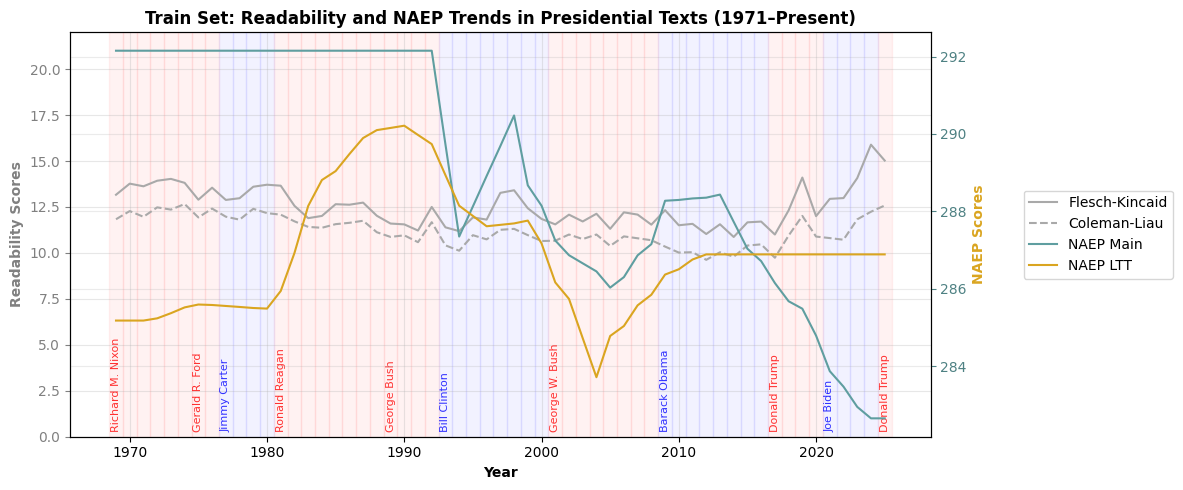

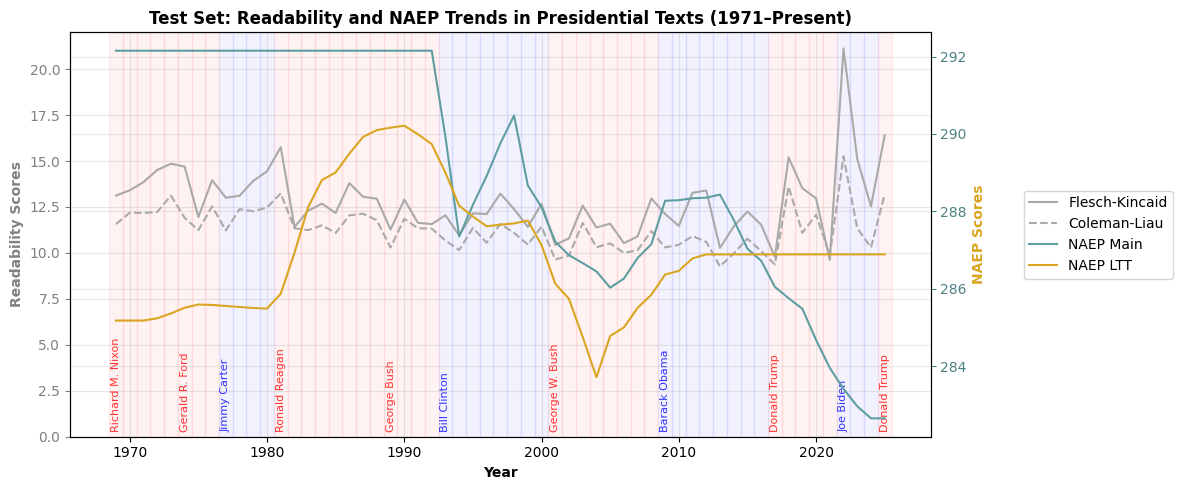

In [33]:
# -----------------------------------------------------------------------
# Plot Train Set: Readability Trends in Presidential Texts (1971–Present)
# -----------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 5))
party_colors = {"Democrat": "Blue", "Republican": "Red"}

# Aggregate readability by year & label
agg = (
    train_data.groupby(["year"])[["Flesch_Kincaid", "Coleman_Liau", "NAEP_Main", "NAEP_LTT"]]
    .mean()
    .reset_index()
)

# Get per-year president and party
yearly_pres = (
    train_data.groupby("year")[["president", "political_party"]]
    .agg(lambda x: x.mode()[0])
    .reset_index()
    .sort_values("year")
)

# Background bars year by year
for _, row in yearly_pres.iterrows():
    plt.axvspan(
        row["year"] - 0.5,
        row["year"] + 0.5,
        color=party_colors.get(row["political_party"], "Blue"),
        alpha=0.05,
        zorder=1
    )

# Add president name when it changes
y_min = min(min(train_data["Flesch_Kincaid"]), min(train_data["Coleman_Liau"]))
y_max = 22
plt.ylim(y_min - y_min * 0.02, y_max + y_max * 0.005)
#y_text = y_min + y_min * 0.1
y_text = 0.25
last_pres = None
for _, row in yearly_pres.iterrows():
    if row["president"] != last_pres:
        plt.text(
            row["year"],
            y_text,
            row["president"],
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=8,
            color=party_colors.get(row["political_party"], "Blue"),
            alpha=0.8,
            zorder=2
        )
        last_pres = row["president"]

# Left axis for readability
ax1.plot(agg["year"], agg["Flesch_Kincaid"], color="DarkGray", label="Flesch-Kincaid", zorder=5)
ax1.plot(agg["year"], agg["Coleman_Liau"], color="DarkGray", linestyle="dashed", label="Coleman-Liau", zorder=6)
ax1.set_ylabel("Readability Scores", color="Gray", fontweight="bold")
ax1.set_xlabel("Year", fontweight="bold")
ax1.set_ylim(0, 22)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis="y", colors="Gray")

# Right axis for NAEP
ax2 = ax1.twinx()
ax2.plot(agg["year"], agg["NAEP_Main"], color="CadetBlue", label="NAEP Main", zorder=3)
ax2.plot(agg["year"], agg["NAEP_LTT"], color="Goldenrod", label="NAEP LTT", zorder=4)
ax2.set_ylabel("NAEP Scores", color="Goldenrod", fontweight="bold")
ax2.tick_params(axis="y", colors="#4E8183")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.1, 0.5))
plt.title("Train Set: Readability and NAEP Trends in Presidential Texts (1971–Present)", fontweight="bold")
plt.grid(True, alpha=0.25, zorder=0)
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------
# Plot Test Set: Readability Trends in Presidential Texts (1971–Present)
# -----------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 5))
party_colors = {"Democrat": "Blue", "Republican": "Red"}

# Aggregate readability by year & label
agg = (
    test_data.groupby(["year"])[["Flesch_Kincaid", "Coleman_Liau", "NAEP_Main", "NAEP_LTT"]]
    .mean()
    .reset_index()
)

# Get per-year president and party
yearly_pres = (
    test_data.groupby("year")[["president", "political_party"]]
    .agg(lambda x: x.mode()[0])
    .reset_index()
    .sort_values("year")
)

# Background bars year by year
for _, row in yearly_pres.iterrows():
    plt.axvspan(
        row["year"] - 0.5,
        row["year"] + 0.5,
        color=party_colors.get(row["political_party"], "Blue"),
        alpha=0.05,
        zorder=1
    )

# Add president name when it changes
y_min = min(min(test_data["Flesch_Kincaid"]), min(test_data["Coleman_Liau"]))
y_max = 22
plt.ylim(y_min - y_min * 0.02, y_max + y_max * 0.005)
y_text = 0.25
last_pres = None
for _, row in yearly_pres.iterrows():
    if row["president"] != last_pres:
        plt.text(
            row["year"],
            y_text,
            row["president"],
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=8,
            color=party_colors.get(row["political_party"], "Blue"),
            alpha=0.8,
            zorder=2
        )
        last_pres = row["president"]

# Left axis for readability
ax1.plot(agg["year"], agg["Flesch_Kincaid"], color="DarkGray", label="Flesch-Kincaid", zorder=5)
ax1.plot(agg["year"], agg["Coleman_Liau"], color="DarkGray", linestyle="dashed", label="Coleman-Liau", zorder=6)
ax1.set_ylabel("Readability Scores", color="Gray", fontweight="bold")
ax1.set_xlabel("Year", fontweight="bold")
ax1.set_ylim(0, 22)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis="y", colors="Gray")

# Right axis for NAEP
ax2 = ax1.twinx()
ax2.plot(agg["year"], agg["NAEP_Main"], color="CadetBlue", label="NAEP Main", zorder=3)
ax2.plot(agg["year"], agg["NAEP_LTT"], color="Goldenrod", label="NAEP LTT", zorder=4)
ax2.set_ylabel("NAEP Scores", color="Goldenrod", fontweight="bold")
ax2.tick_params(axis="y", colors="#4E8183")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.1, 0.5))
plt.title("Test Set: Readability and NAEP Trends in Presidential Texts (1971–Present)", fontweight="bold")
plt.grid(True, alpha=0.25, zorder=0)
plt.tight_layout()
plt.show()


print("")

<br>

---
---
## **Discussion and Conclusion**

---
### **Lessons Learned**

Despite the the downward trends shown in both NAEP reading level scores and the readability level of presidential texts seen in our initial EDA, this appears to be coincidental since our data showed that `text_category` had the highest relative importance when calculating either Flesch-Kincaid or Coleman-Liau readability levels. Categorization of a text as either public-facing or internal did not contribute strongly to readability levels either. Surprsingly, neither NAEP Main not NAEP LTT reading showed a strong association with readability levels. The same could be said for political party and president, suggesting that blame for lowered readability levels shouldn't be pinned solely on either side.

<br>

---
### **Data Limitations**

The conclusions drawn from our readability analysis were based on the categorization results from our unsupervised learning model. Since our NMF models only gave us a weak to moderate adjusted Rand scores for both our train and test sets, we cannot consider this definitive ground truth for our readablity analysis.

<br>

---
### **Possible Improvements**

Our analysis showed that `text_category` had the highest contribution to both readability level scores, so further examination of that data subset might yield more information to explain lower Flesch-Kincaid and Coleman-Liau scores over time.

<br>

---
---
## References

---

- Harris, S. (2025, January 29). *The Nation’s Report Card Shows Declines in Reading, Some Progress in 4th Grade Math.* Nagb.gov; National Assessment Governing Board. https://www.nagb.gov/news-and-events/news-releases/2025/nations-report-card-decline-in-reading-progress-in-math.html

* *NAEP Nation’s Report Card - The NAEP Reading Achievement Levels by Grade.* (2022, October 17). Nces.ed.gov. https://nces.ed.gov/nationsreportcard/reading/achieve.aspx#2009ald

* NAEP - *Long-Term Trend: Reading Performance-Level Descriptions.* (2022). Ed.gov; National Center for Education Statistics. https://nces.ed.gov/nationsreportcard/ltt/reading-descriptions.aspx

* Britannica. (2020). *Presidents of the United States | Britannica.* In M. Johnston (Ed.), Encyclopædia Britannica. https://www.britannica.com/topic/Presidents-of-the-United-States-1846696

* Peters, G., & Woolley, J. T. (Eds.). (1999–). *The American Presidency Project*. University of California, Santa Barbara. https://www.presidency.ucsb.edu/

* Kincaid, J.P.; Fishburne, R.P.; Rogers, R.L.; Chissom, B.S. (1975). *Derivation of new readability formulas (automated readability index, fog count, and flesch reading ease formula) for Navy enlisted personnel (PDF) (Report).* Naval Air Station Memphis: Chief of Naval Technical Training. Research Branch Report 8–75. Retrieved October 15, 2024.https://apps.dtic.mil/sti/pdfs/ADA006655.pdf

* Coleman, M., & Liau, T. L. (1975). A computer readability formula designed for machine scoring. *Journal of Applied Psychology*, 60(2), 283–284. https://doi.org/10.1037/h0076540